---
title: Bicycle Demand Prediction
jupyter: python3
---

# Bicycle Demand Prediction 

- 아래 내용은 '머신러닝•딥러닝 문제해결전략 (신백균 저)' `Chap 06` 실습 내용 + 추가 공부 내용 을 정리한 것입니다.

In [1]:
import os

PROJECT_NAME = "bike-sharing-demand"

def is_kaggle():
    # Kaggle Notebook 에서는 일반적으로 아래 env가 존재함
    return (
        os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None or
        os.path.exists("/kaggle/input")
    )

data_path = None
if is_kaggle():
    print("📌 Kaggle 환경 감지")

    # Kaggle일 경우 input 내부 모든 파일 탐색
    for dirname, _, filenames in os.walk("/kaggle/input"):
        if PROJECT_NAME in dirname:   # competition dataset 디렉토리 찾기
            data_path = dirname
            break

    if data_path is None:
        raise FileNotFoundError(f"{PROJECT_NAME} 관련 데이터를 Kaggle input에서 찾지 못함.")
    else:
        print(f"DATA_PATH = {data_path}")

else:
    print("📌 Local 환경 감지")

    cwd = os.getcwd()

    print(f"cwd = {cwd}")
    if PROJECT_NAME in cwd:
        data_path = os.path.join(cwd, "input")
    else:
        data_path = os.path.join(cwd, PROJECT_NAME, "input")

    print(f"DATA_PATH = {data_path}")

📌 Kaggle 환경 감지
DATA_PATH = /kaggle/input/bike-sharing-demand


## 탐색적 데이터 분석

### 라이브러리, 데이터 파일 준비

In [2]:
import numpy as np  # 넘파이 임포트
import pandas as pd  # 판다스 임포트

print("data_path =", data_path) 
train = pd.read_csv(os.path.join(data_path, "train.csv"))  # 훈련 데이터
test = pd.read_csv(os.path.join(data_path, "test.csv"))  # 테스트 데이터
submission = pd.read_csv(os.path.join(data_path, "sampleSubmission.csv"))  # 제출 샘플 데이터

data_path = /kaggle/input/bike-sharing-demand


### 훈련 데이터, 테스트 데이터 크기 확인

In [3]:
print("shape - train: ", train.shape, ", test: ", test.shape)

shape - train:  (10886, 12) , test:  (6493, 9)


### 각 데이터별 Feature 확인

In [4]:
print("[columns]")
print("train - ", train.columns)
print(train.head())
print("test - ", test.columns)
print(test.head())

[columns]
train -  Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')
              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
test -  Index(['datetime', 'se

- `train` 데이터 셋에는 `casual`, `registered` 가 있으나 `test` 데이터셋에는 없음

### 제출 샘플 파일 확인

In [5]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


### `DataFrame.info()` 를 통한 결측값, 데이터 타입 파악

#### `train.info()`

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- `train` 데이터셋에 결측치는 존재하지 않음

#### `test.info()`

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### 피처 엔지니어링

#### `datetime feature` 변환

##### `datetime feature` 형태 확인

In [8]:
print(train['datetime'][100]) # datetime 100번째 원소
print(train['datetime'][100].split()) # 공백 기준 문자열 나누기
print(train['datetime'][100].split()[0]) # 날짜
print(train['datetime'][100].split()[1]) # 시간
print(train['datetime'][100].split()[0].split("-")) # "-" 기준으로 문자열 나누기
print(train['datetime'][100].split()[0].split("-")[0]) # 연도
print(train['datetime'][100].split()[0].split("-")[1]) # 월
print(train['datetime'][100].split()[0].split("-")[2]) # 일
print(train['datetime'][100].split()[1].split(":")) # "-" 기준으로 문자열 나누기
print(train['datetime'][100].split()[1].split(":")[0]) # 연도
print(train['datetime'][100].split()[1].split(":")[1]) # 월
print(train['datetime'][100].split()[1].split(":")[2]) # 일

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
09:00:00
['2011', '01', '05']
2011
01
05
['09', '00', '00']
09
00
00


##### `datetie feature` 가공을 통한 새로운 피처 추가

In [9]:
from datetime import datetime
import calendar

train["date"] = train["datetime"].apply(lambda x: x.split()[0])  # 날짜 피처 생성

# 연도, 월, 일, 시, 분, 초 피처를 차례로 생성
train["year"] = train["datetime"].apply(lambda x: x.split()[0].split("-")[0])
train["month"] = train["datetime"].apply(lambda x: x.split()[0].split("-")[1])
train["day"] = train["datetime"].apply(lambda x: x.split()[0].split("-")[2])
train["hour"] = train["datetime"].apply(lambda x: x.split()[1].split(":")[0])
train["minute"] = train["datetime"].apply(lambda x: x.split()[1].split(":")[1])
train["second"] = train["datetime"].apply(lambda x: x.split()[1].split(":")[2])

train["weekday"] = train["date"].apply(lambda dateString: calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

In [10]:
train["season(str)"] = train["season"].map(
    {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}
)

train["weather(str)"] = train["weather"].map(
    {
        1: "Clear",
        2: "Mist, Few clouds",
        3: "Light Snow, Rain, Thunderstorm",
        4: "Heavy Rain, Thunderstorm, Snow, Fog",
    }
)

In [11]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,date,year,month,day,hour,minute,second,weekday,season(str),weather(str)
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,2011-01-01,2011,01,01,00,00,00,Saturday,Spring,Clear
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,2011-01-01,2011,01,01,01,00,00,Saturday,Spring,Clear
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,2011-01-01,2011,01,01,02,00,00,Saturday,Spring,Clear
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,2011-01-01,2011,01,01,03,00,00,Saturday,Spring,Clear
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,2011-01-01,2011,01,01,04,00,00,Saturday,Spring,Clear


### 데이터 시각화

#### Library Import

In [12]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#### 분포도

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


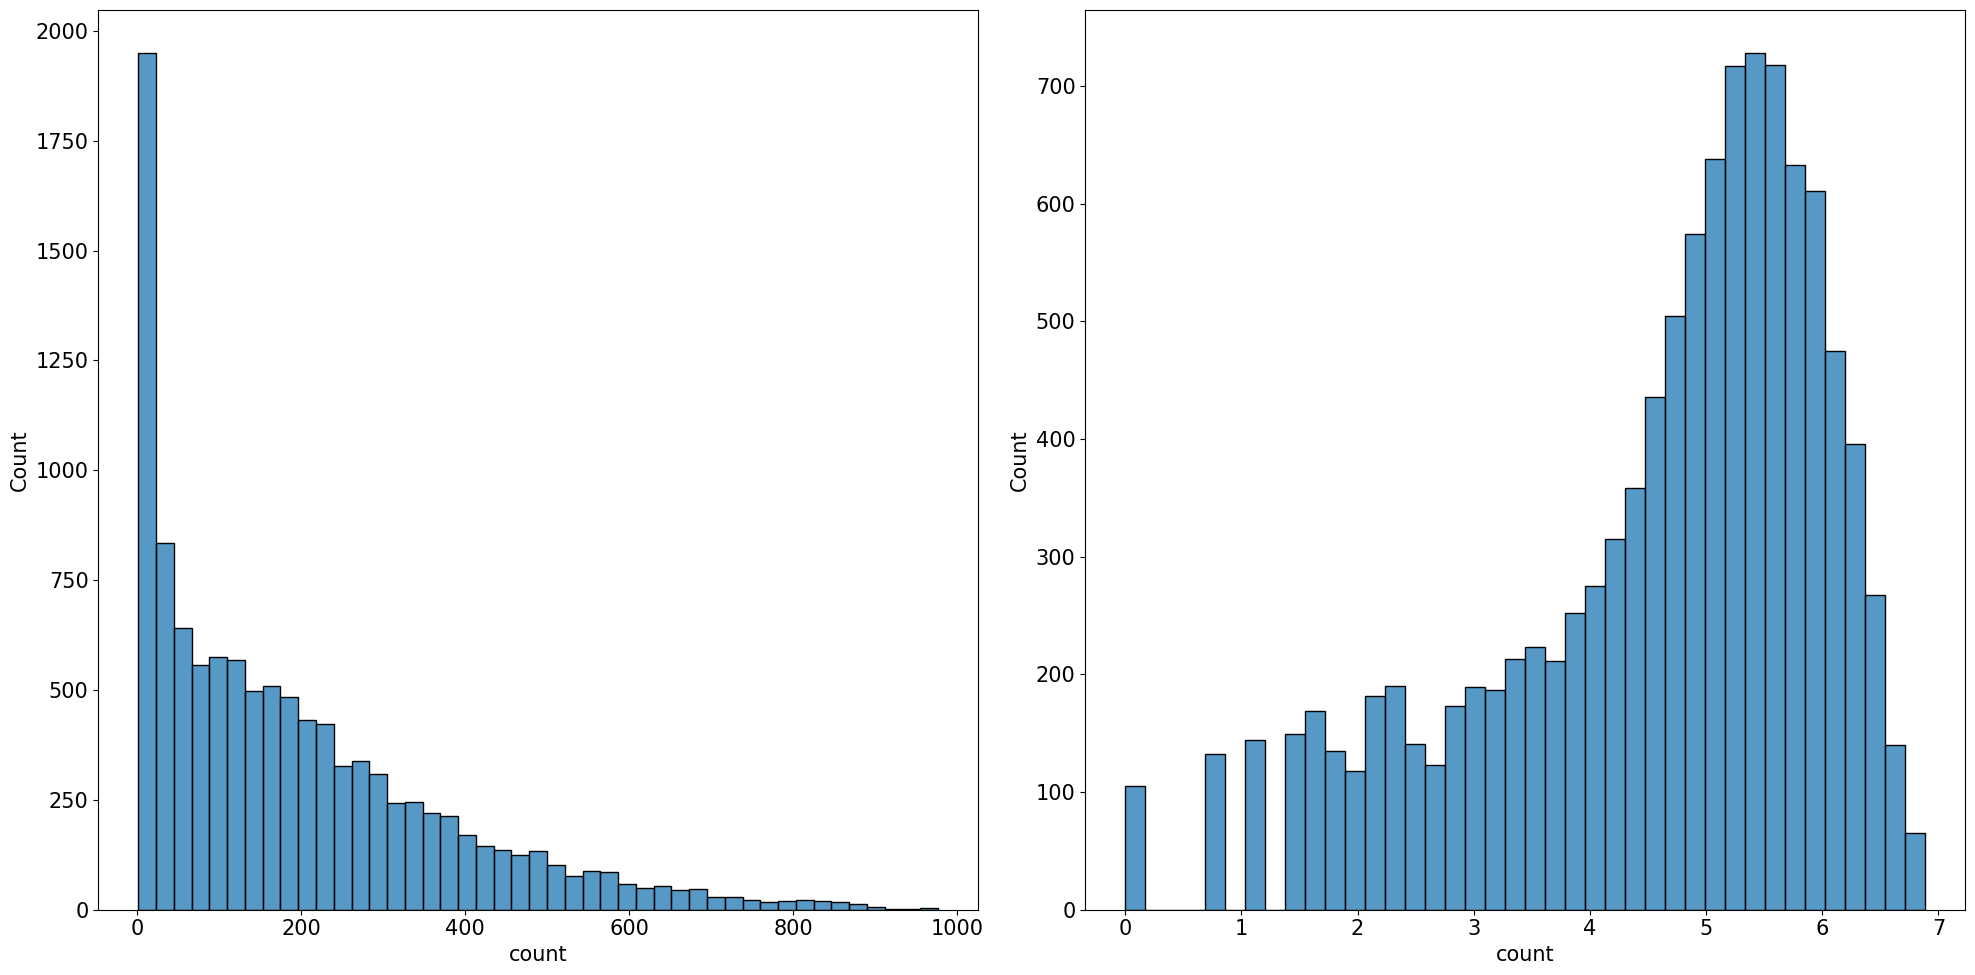

In [13]:
mpl.rc("font", size=15)  # 폰트 크기를 15로 설정
figure, axes = plt.subplots(nrows = 1, ncols = 2)
figure.set_size_inches(20, 10)
sns.histplot(train["count"], ax = axes[0])
sns.histplot(np.log(train["count"]), ax = axes[1])
plt.tight_layout()

#### 막대 그래프

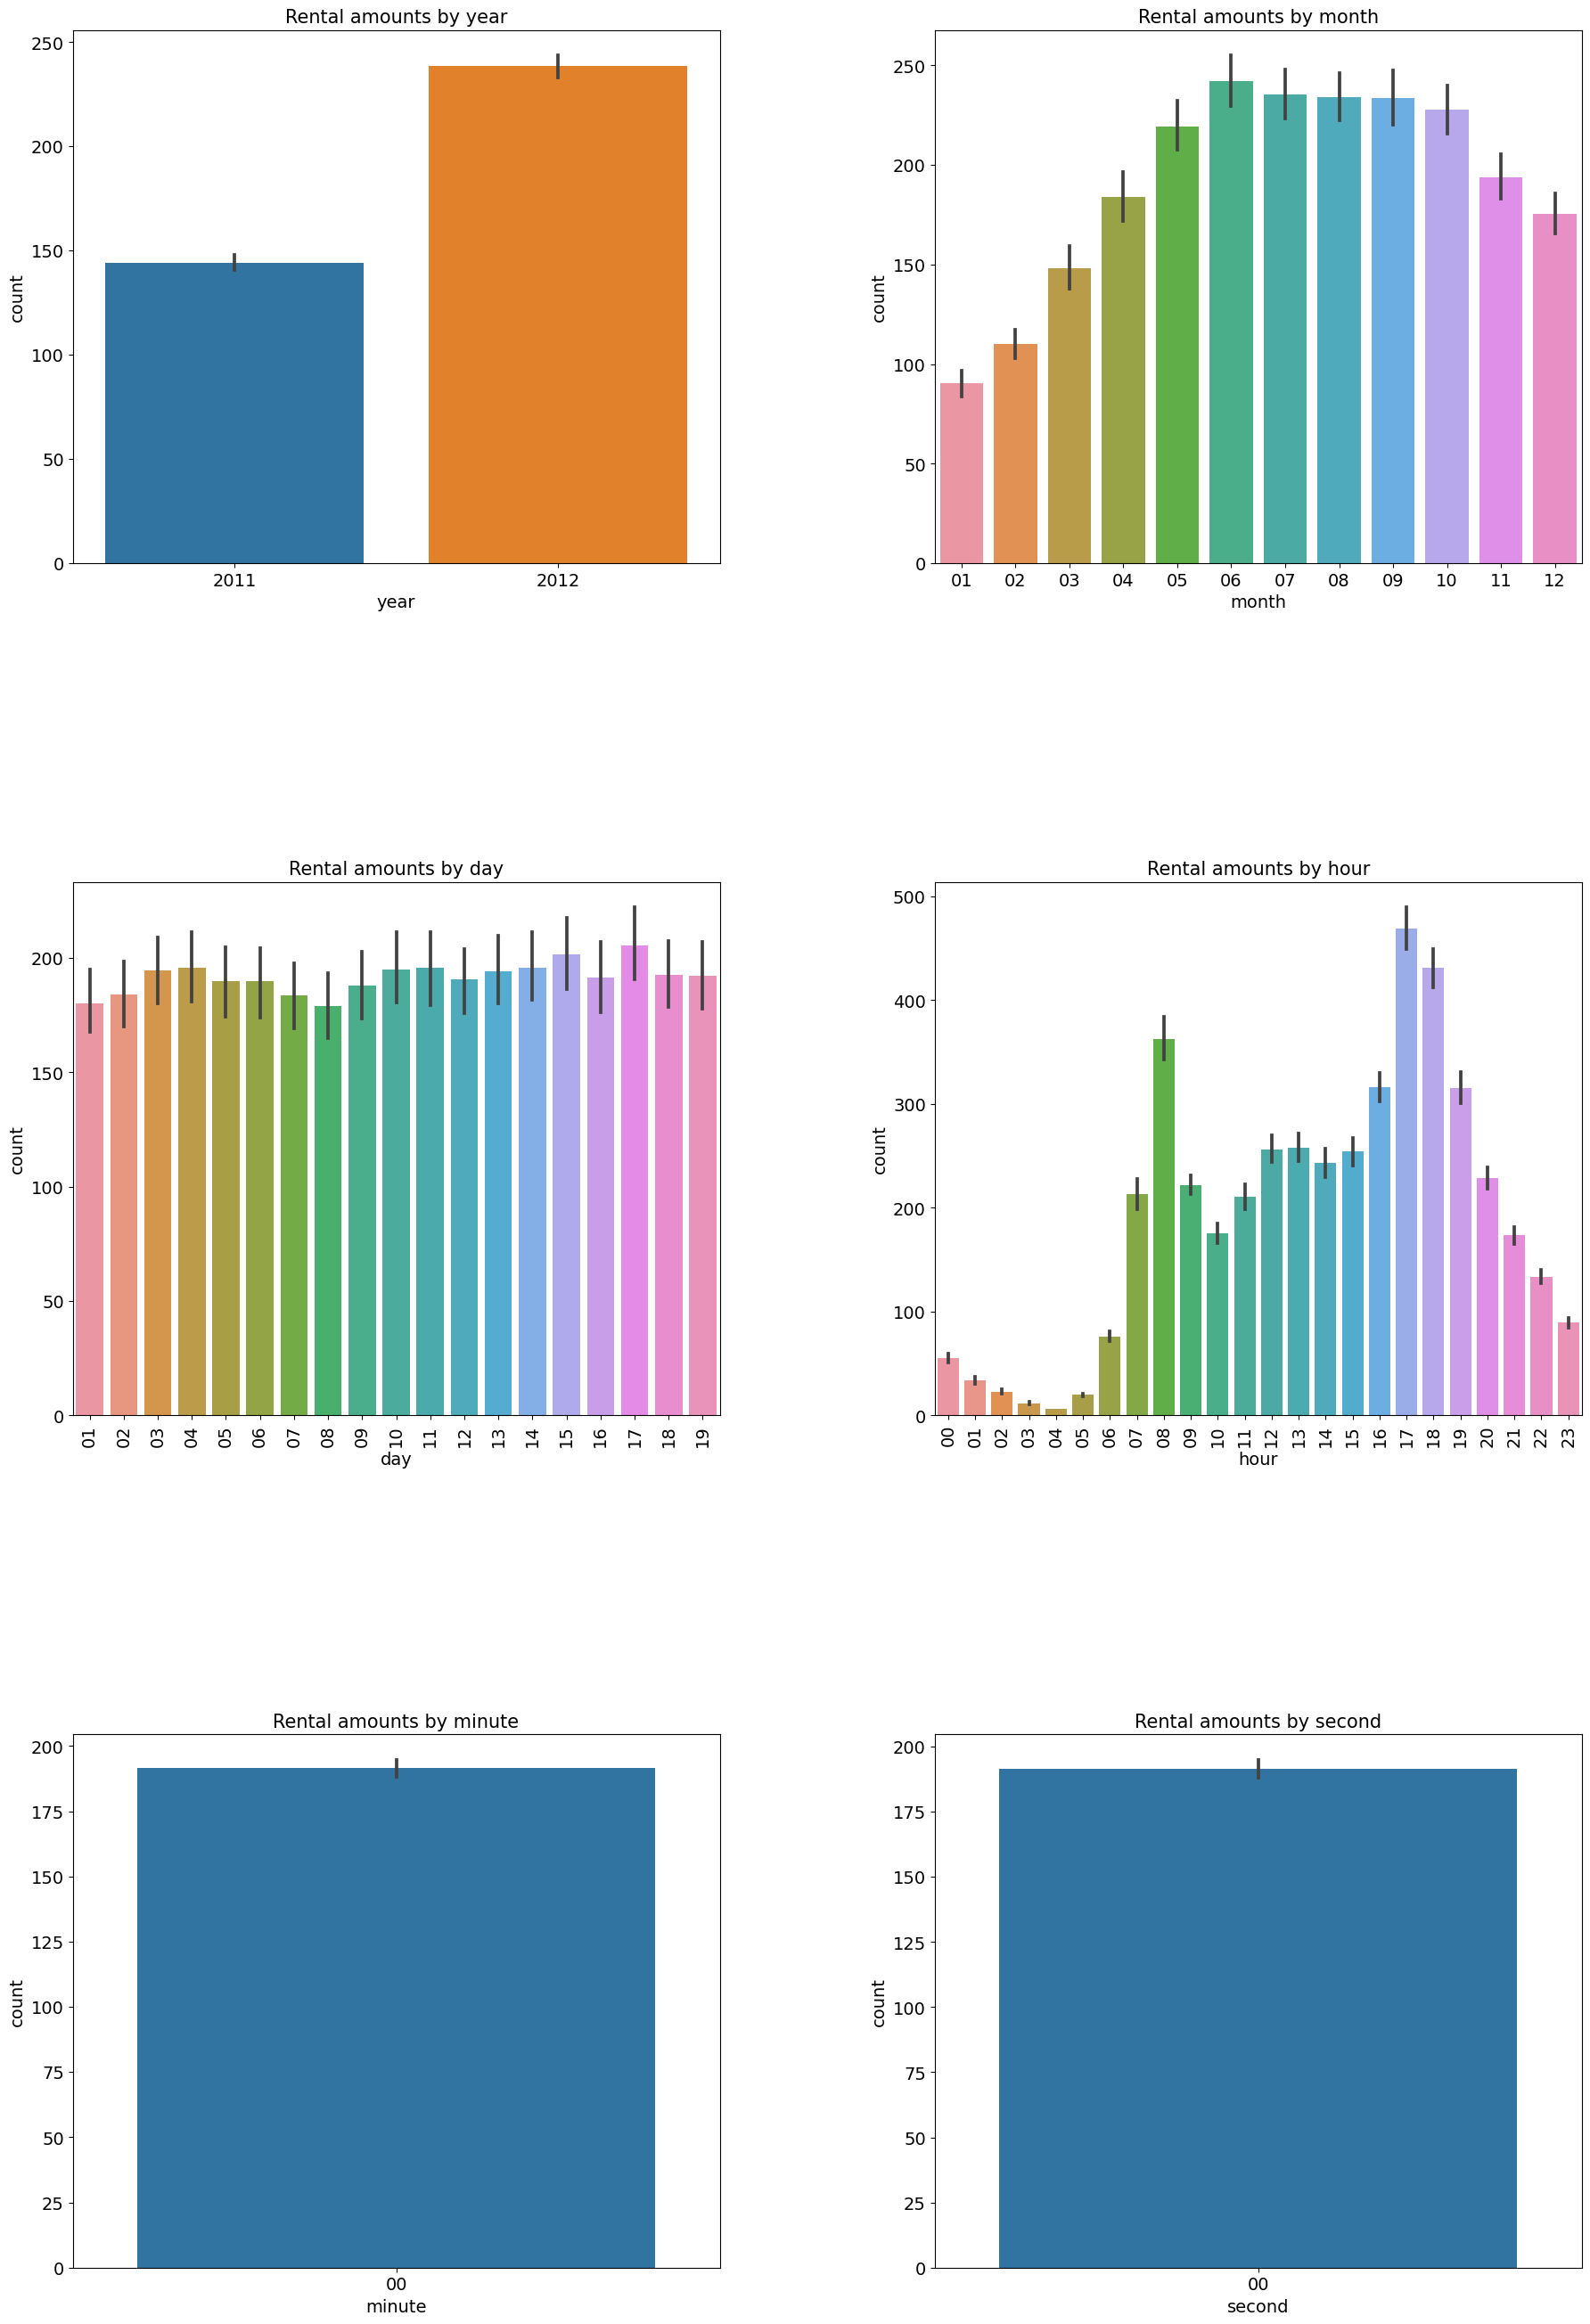

In [14]:
mpl.rc("font", size=14)  #  폰트 크기 설정
mpl.rc("axes", titlesize=15)  #  각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2)  #  3행 2열 Figure 생성
plt.tight_layout()  #  그래프 사이에 여백 확보
figure.set_size_inches(20, 30)  #  전체 Figure 크기를 10 x 9 인치로 설정

sns.barplot(x="year", y="count", data=train, ax=axes[0, 0])
sns.barplot(x="month", y="count", data=train, ax=axes[0, 1])
sns.barplot(x="day", y="count", data=train, ax=axes[1, 0])
sns.barplot(x="hour", y="count", data=train, ax=axes[1, 1])
sns.barplot(x="minute", y="count", data=train, ax=axes[2, 0])
sns.barplot(x="second", y="count", data=train, ax=axes[2, 1])

axes[0, 0].set(title="Rental amounts by year")
axes[0, 1].set(title="Rental amounts by month")
axes[1, 0].set(title="Rental amounts by day")
axes[1, 1].set(title="Rental amounts by hour")
axes[2, 0].set(title="Rental amounts by minute")
axes[2, 1].set(title="Rental amounts by second")

axes[1, 0].tick_params(axis="x", labelrotation=90)
axes[1, 1].tick_params(axis="x", labelrotation=90)

#### 박스플롯

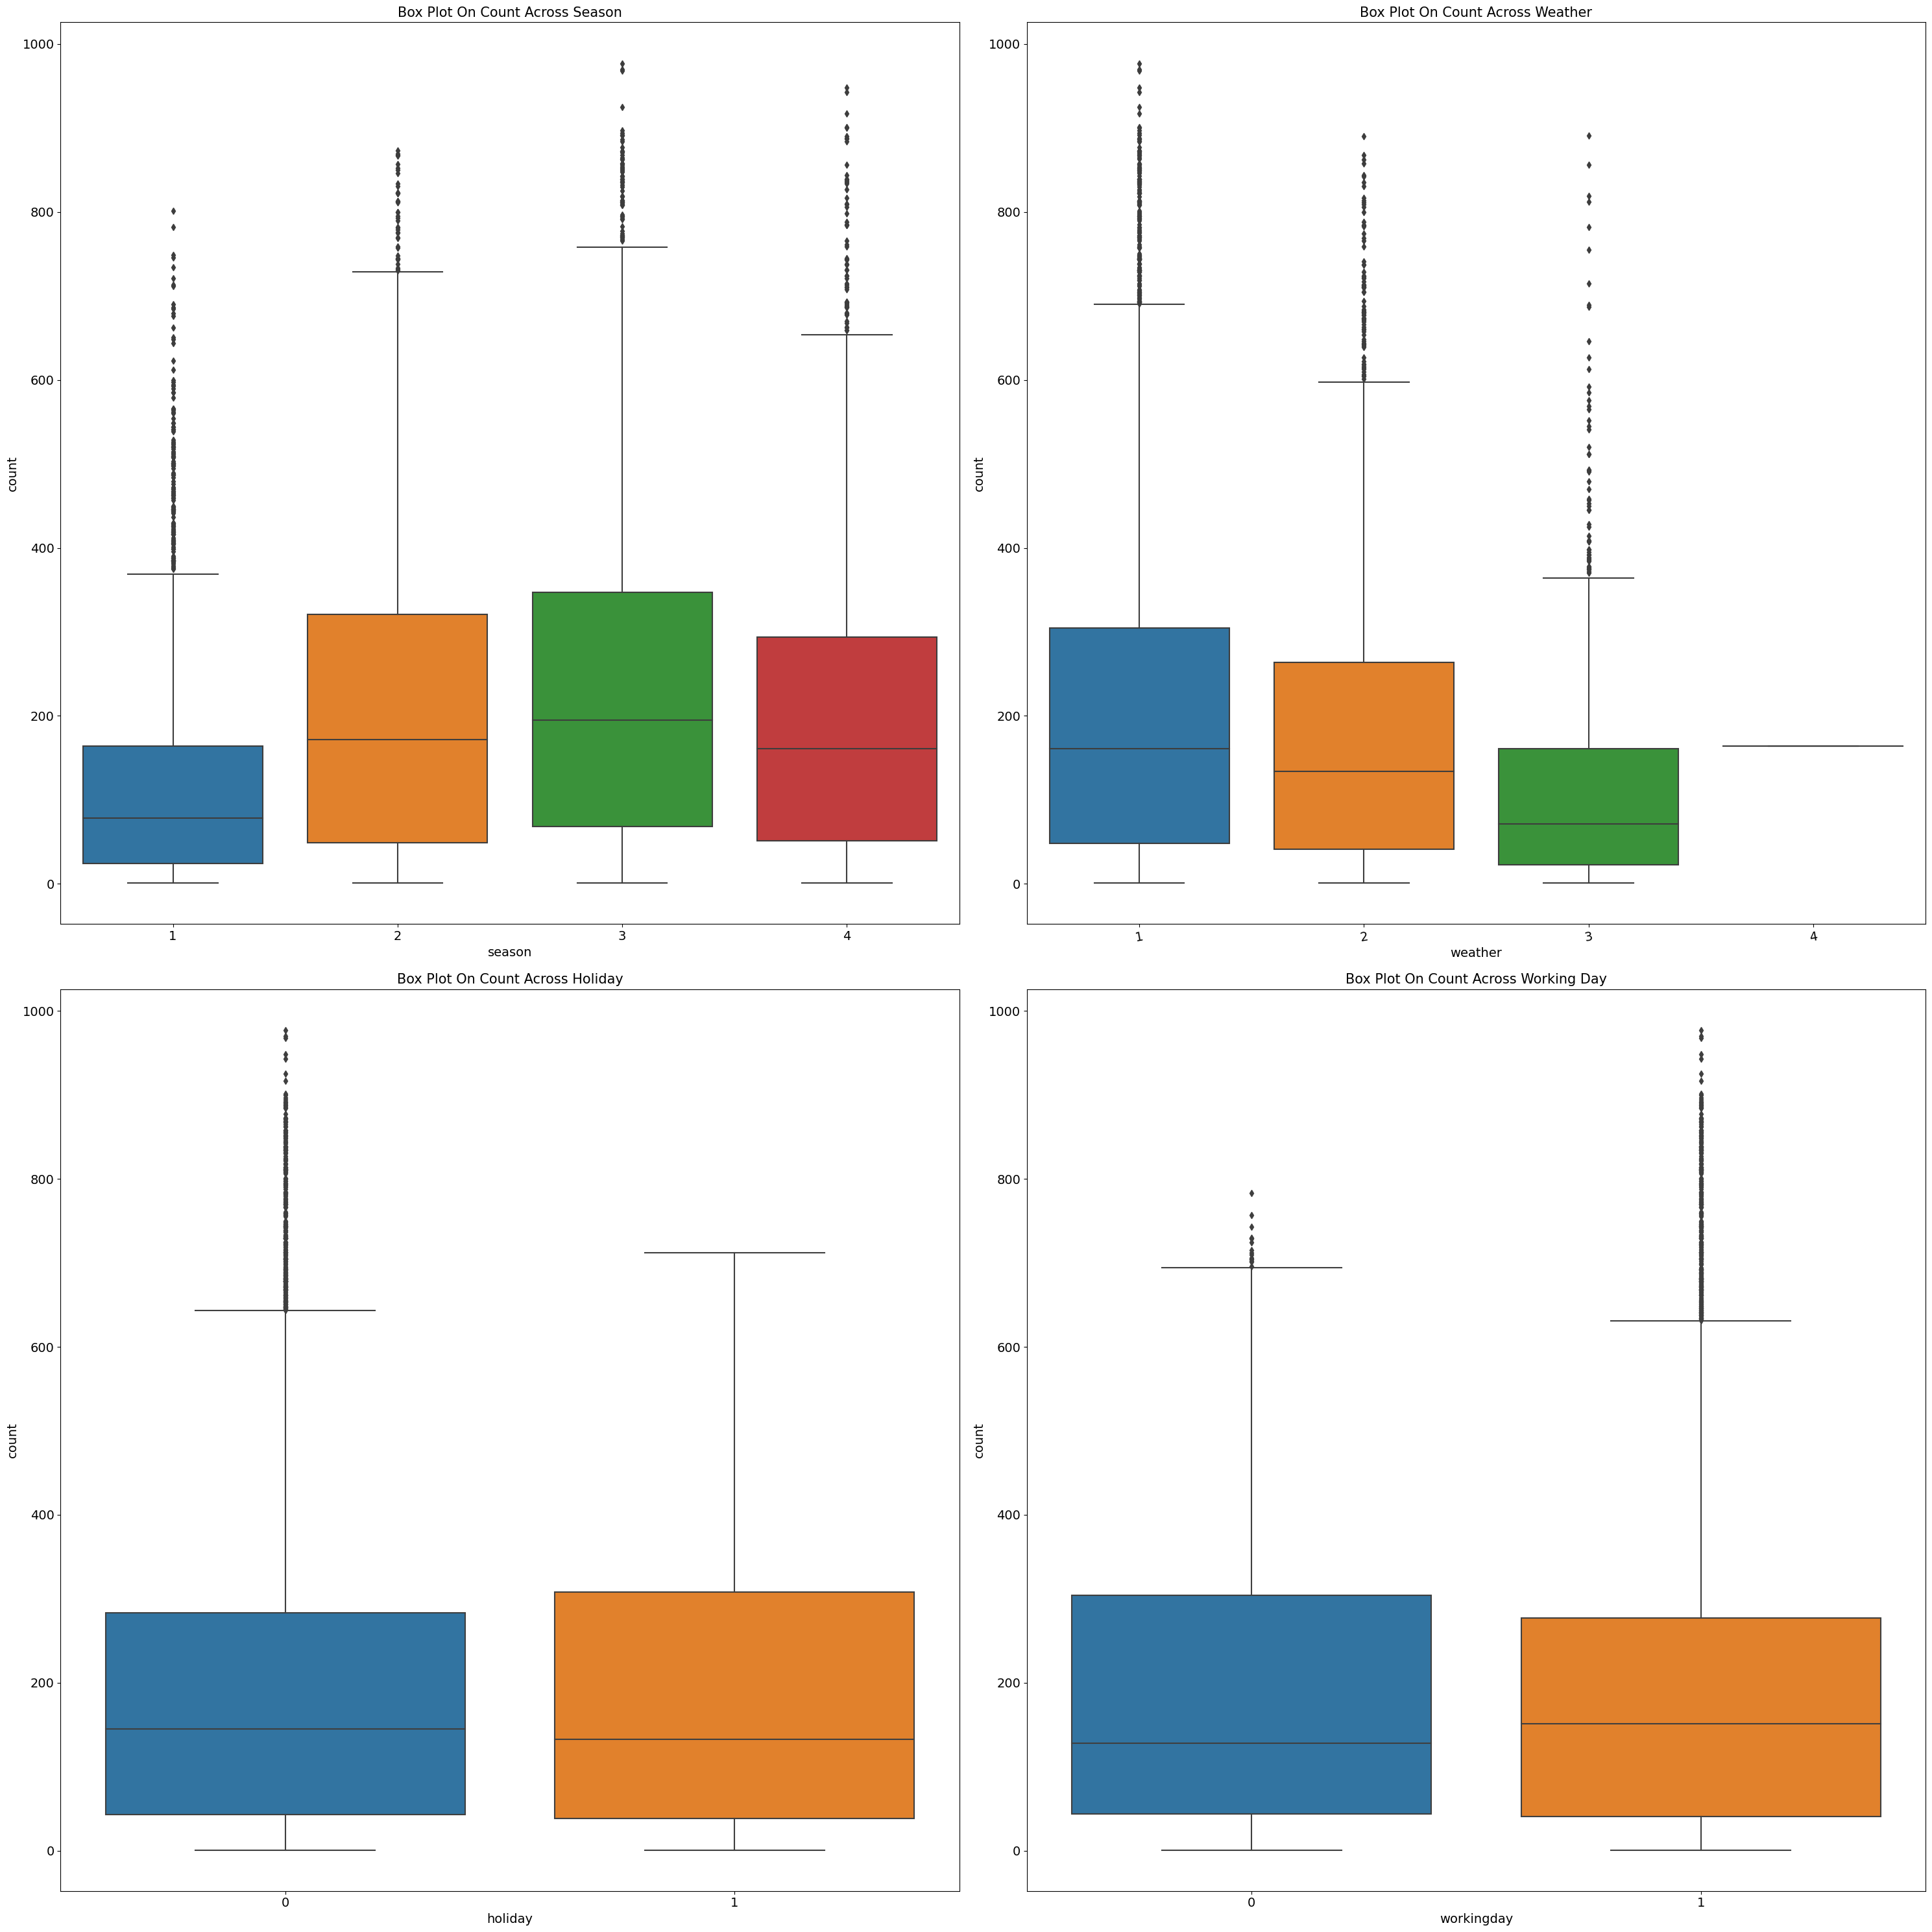

In [15]:
# 스텝 1: m행 n열 Figure 준비
figure, axes = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(30, 30)

# 스텝 2: 서브플롯 할당
# 계절, 날씨, 공휴일, 근무일별 대여 수량 박스플롯
sns.boxplot(x="season", y="count", data=train, ax=axes[0, 0])
sns.boxplot(x="weather", y="count", data=train, ax=axes[0, 1])
sns.boxplot(x="holiday", y="count", data=train, ax=axes[1, 0])
sns.boxplot(x="workingday", y="count", data=train, ax=axes[1, 1])

# 스텝 3: 세부 설정
# 3-1: 서브플롯에 제목 달기
axes[0, 0].set(title="Box Plot On Count Across Season")
axes[0, 1].set(title="Box Plot On Count Across Weather")
axes[1, 0].set(title="Box Plot On Count Across Holiday")
axes[1, 1].set(title="Box Plot On Count Across Working Day")

axes[0, 1].tick_params(axis="x", labelrotation=10)

plt.tight_layout()

<Axes: xlabel='hour', ylabel='count'>

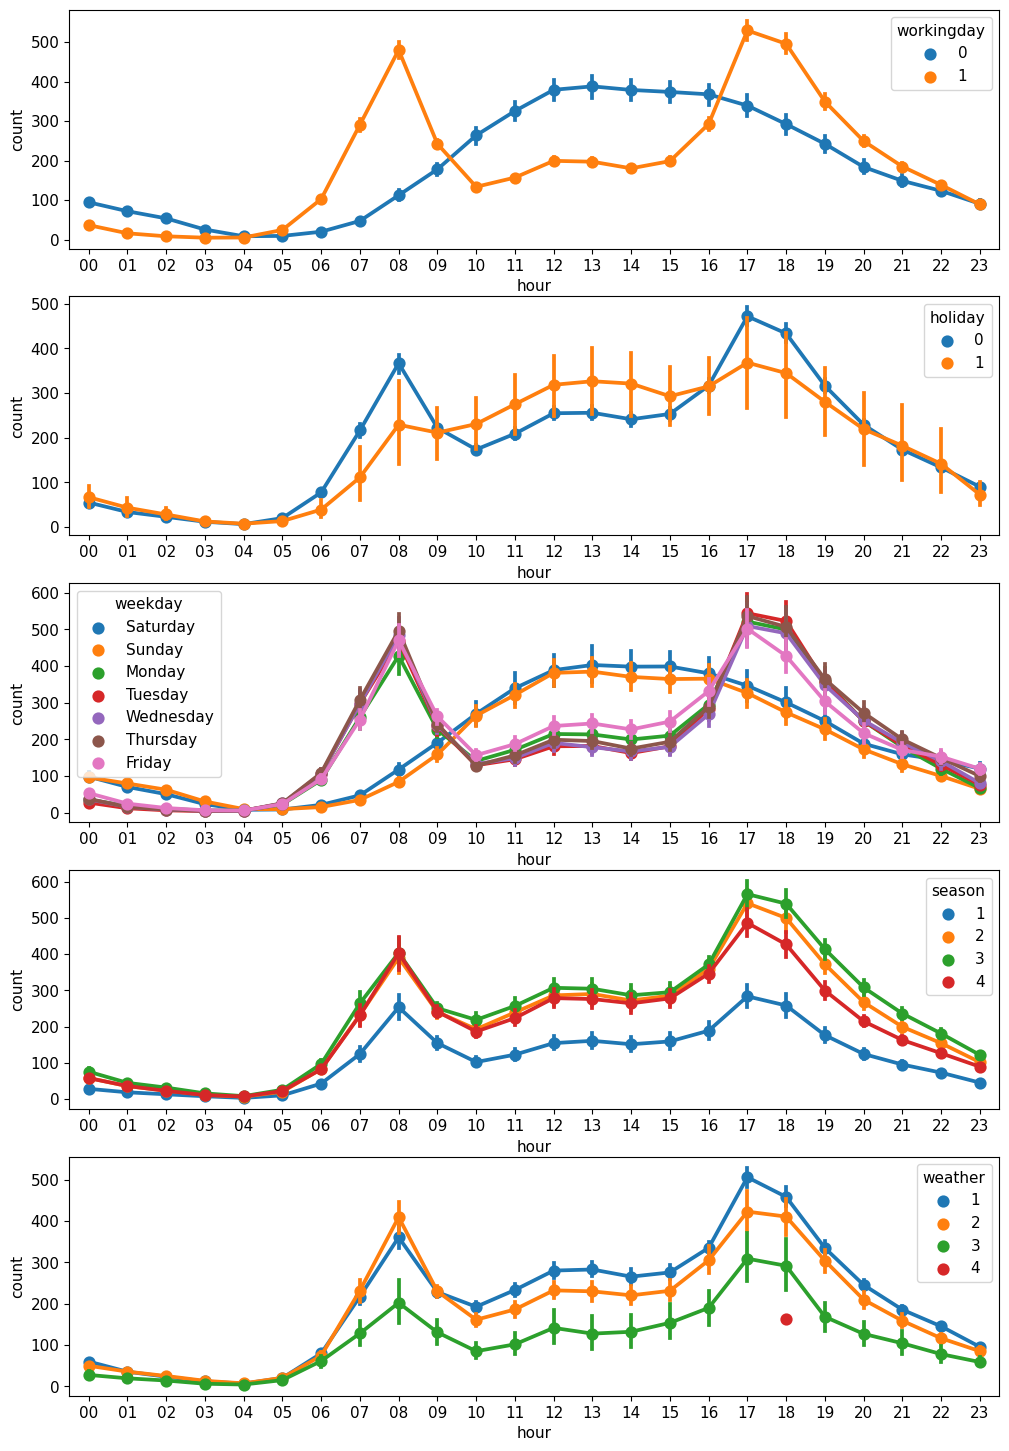

In [16]:
# 스텝 1: m행 n열 Figure 준비
mpl.rc("font", size=11)
figure, axes = plt.subplots(nrows=5)  # 5행 1열
figure.set_size_inches(12, 18)

# 스텝 2: 서브플롯 할당
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트플롯
sns.pointplot(x="hour", y="count", data=train, hue="workingday", ax=axes[0])
sns.pointplot(x="hour", y="count", data=train, hue="holiday", ax=axes[1])
sns.pointplot(x="hour", y="count", data=train, hue="weekday", ax=axes[2])
sns.pointplot(x="hour", y="count", data=train, hue="season", ax=axes[3])
sns.pointplot(x="hour", y="count", data=train, hue="weather", ax=axes[4])

- `weather` 빨간색 점은 이상치.

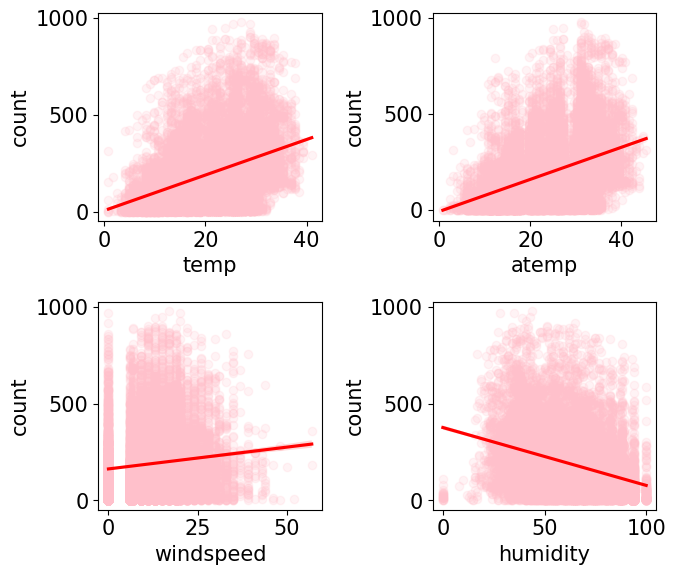

In [17]:
# 스텝 1: m행 n열 Figure 준비
mpl.rc("font", size=15)
figure, axes = plt.subplots(nrows=2, ncols=2)  # 2형 2열
figure.set_size_inches(7, 6)

# 스텝 2: 서브플롯 할당
# 온도, 체감 온도, 풍속, 습도 별 대여 수량 산점도 그래프
sns.regplot(
    x="temp",
    y="count",
    data=train,
    ax=axes[0, 0],
    scatter_kws={"alpha": 0.18, "color": "pink"},
    line_kws={"color": "red"},
)
sns.regplot(
    x="atemp",
    y="count",
    data=train,
    ax=axes[0, 1],
    scatter_kws={"alpha": 0.18, "color": "pink"},
    line_kws={"color": "red"},
)
sns.regplot(
    x="windspeed",
    y="count",
    data=train,
    ax=axes[1, 0],
    scatter_kws={"alpha": 0.18, "color": "pink"},
    line_kws={"color": "red"},
)
sns.regplot(
    x="humidity",
    y="count",
    data=train,
    ax=axes[1, 1],
    scatter_kws={"alpha": 0.18, "color": "pink"},
    line_kws={"color": "red"},
)

plt.tight_layout()

- `windspeed` 데이터 값이 `0`이 많음  - 실제 풍속이 0이 아니라 관측치가 없거나, 오류로 인해 0으로 기록됐을 가능성이 높음.  - 결측값이 많은 경우 대체하거나 feature 자체를 삭제하는 것이 좋음

[Text(0.5, 1.0, 'Heatmap of Numerical Data')]

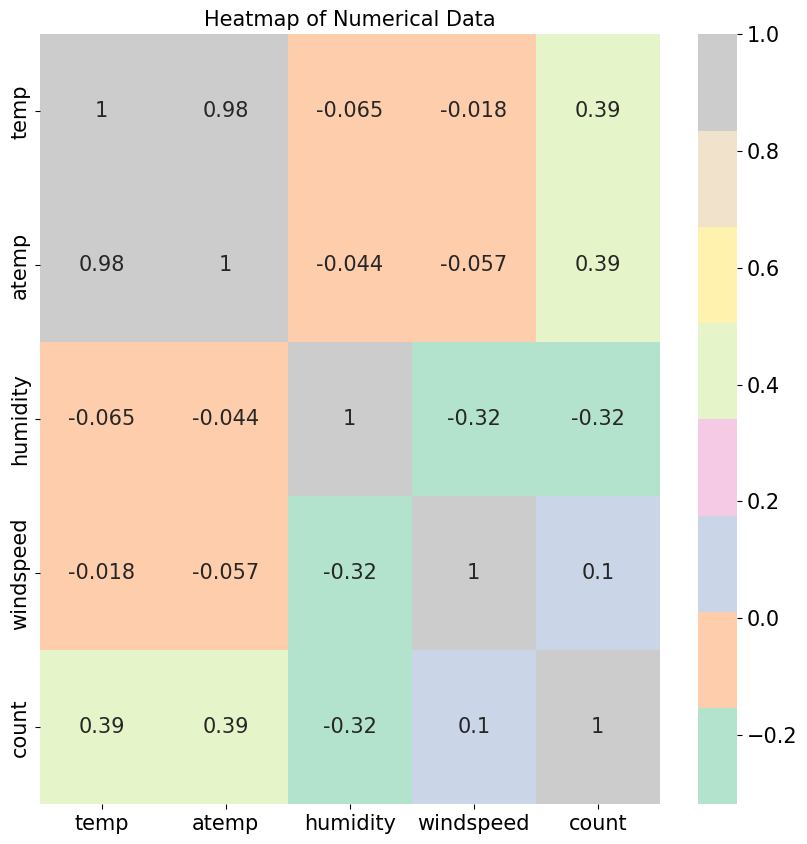

In [18]:
# 피쳐 간 상관관계 매트릭스
train[["temp", "atemp", "humidity", "windspeed", "count"]].corr()

corrMat = train[["temp", "atemp", "humidity", "windspeed", "count"]].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True, cmap="Pastel2")  # 상관관계 히트맵 그리기
ax.set(title="Heatmap of Numerical Data")

## 모델링 - 베이스라인 모델 (선형 회귀)

### 데이터셋 다시 불러오기

In [19]:
import numpy as np  # 넘파이 임포트
import pandas as pd  # 판다스 임포트

print("data_path =", data_path) 
train = pd.read_csv(os.path.join(data_path, "train.csv"))  # 훈련 데이터
test = pd.read_csv(os.path.join(data_path, "test.csv"))  # 테스트 데이터
submission = pd.read_csv(os.path.join(data_path, "sampleSubmission.csv"))  # 제출 샘플 데이터

data_path = /kaggle/input/bike-sharing-demand


### 피처 엔지니어링

#### 이상치 제거

In [20]:
# 훈련 데이터에서 weather 가 4 가 아닌 데이터만 추출
train = train[train["weather"] != 4]

#### 학습 데이터셋, 테스트 데이터셋 병합

In [21]:
# 피처 엔지니어링을 위해 학습용 데이터, 테스트용 데이터셋 병합
all_data = pd.concat([train, test], ignore_index=True)
print(all_data)

                  datetime  season  holiday  workingday  weather   temp  \
0      2011-01-01 00:00:00       1        0           0        1   9.84   
1      2011-01-01 01:00:00       1        0           0        1   9.02   
2      2011-01-01 02:00:00       1        0           0        1   9.02   
3      2011-01-01 03:00:00       1        0           0        1   9.84   
4      2011-01-01 04:00:00       1        0           0        1   9.84   
...                    ...     ...      ...         ...      ...    ...   
17373  2012-12-31 19:00:00       1        0           1        2  10.66   
17374  2012-12-31 20:00:00       1        0           1        2  10.66   
17375  2012-12-31 21:00:00       1        0           1        1  10.66   
17376  2012-12-31 22:00:00       1        0           1        1  10.66   
17377  2012-12-31 23:00:00       1        0           1        1  10.66   

        atemp  humidity  windspeed  casual  registered  count  
0      14.395        81     0.0000 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


#### 파생 피처 추가

In [22]:
from datetime import datetime

all_data["date"] = all_data["datetime"].apply(lambda x: x.split()[0])  # '날짜' 피처 생성
all_data["year"] = all_data["datetime"].apply(lambda x: x.split()[0].split("-")[0])  # '연도' 피처 생성
all_data["month"] = all_data["datetime"].apply(lambda x: x.split()[0].split("-")[1])  # '월' 피처 생성
all_data["hour"] = all_data["datetime"].apply(lambda x: x.split()[1].split(":")[0])  # '시' 피처 생성
all_data["weekday"] = all_data["date"].apply(lambda dateString: datetime.strptime(dateString, "%Y-%m-%d").weekday())  # '요일' 피처 생성

#### 불필요 피처 제거

In [23]:
drop_features = ["casual", "registered", "datetime", "date", "month", "windspeed"]

all_data = all_data.drop(drop_features, axis=1)

#### 학습 데이터셋, 테스트 데이터셋 분리

In [24]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data["count"])]
X_test = all_data[pd.isnull(all_data["count"])]

# 타깃값 count 제거
X_train = X_train.drop(["count"], axis=1)
X_test = X_test.drop(["count"], axis=1)

y = train["count"]  #  타깃값

X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


### 모델 훈련

In [25]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

log_y = np.log(y)  # 타깃값 로그변환
linear_reg_model.fit(X_train, log_y)  # 모델 훈련

LinearRegression()

### 테스트 예측

In [26]:
preds = linear_reg_model.predict(X_train)

### 모델 성능 검증

#### 평가지표(RMSLE) 계산 함수 작성

##### RMSLE (Root Mean Squared Logarithmic Error)

$$\text{RMSLE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (\log(p_i + 1) - \log(a_i + 1))^2}$$

- 특징
  - 절대 오차가 아니라 “로그 변환된 값의 차이”를 보기 때문에, 값의 크기보다 상대적인 비율 차이에 더 민감하게 반응한다.
  - 값이 클수록 오차가 커지는 RMSE에 비해, RMSLE는 큰 값에서의 큰 오차 영향이 완화되고 이상치에 덜 민감한 편이다.
  - 예측이 실제보다 작은 경우(언더프레딕션)에 더 큰 패널티를 주는 경향이 있어, 수요·재고 예측처럼 모자라면 곤란한 문제에서 자주 쓰인다.

- 언제 사용하면 좋은가
  - 타깃이 0 이상이며 분포가 한쪽으로 치우쳐 있고, 값의 규모가 클수록 오차의 절대값도 커지는 수요·매출·트래픽 예측 같은 문제에 적합하다.
  - “실제의 2배로 예측”과 “실제의 절반으로 예측”을 비슷한 수준의 실수로 취급하고 싶을 때, 즉 비율 기반 성능이 중요한 경우에 적합하다.

In [27]:
def rmsle(y_true, y_pred, convertExp=True):
    #  지수변환 1
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred) ** 2))

    return output

print(f"선형회귀의 RMSLE 값: {rmsle(log_y, preds, True):.4f}")

선형회귀의 RMSLE 값: 1.0205


### 최종 테스트 예측 및 결과 제출

In [28]:
linearreg_preds = linear_reg_model.predict(X_test)  #  테스트 데이터로 예측

submission["count"] = np.exp(linearreg_preds)  #  지수변환

submission.to_csv("submission.csv", index=False)  #  파일로 저장